# Introduction
Author: Lazaros Gogos

AEM: 3877

This python notebook contains the exploration of AutoEncoder architectures, when trying to reconstruct images of MNIST. Also these images will be passed through an already trained CNN to test whether they can be classified correctly.

---

Let's begin!

# Initial Code
Some imports and functions we will need.

In [2]:
import numpy as np

import tensorflow as tf

from tensorflow import keras
from keras.utils import plot_model, to_categorical
from keras import layers, models
from keras.models import load_model

import matplotlib.pyplot as plt
import pickle
import random

import sklearn
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

In [3]:
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.4 MB/s eta 0:00:00
time: 281 µs (started: 2023-12-31 14:47:12 +00:00)


In [4]:
# necessary functions
def _plotModel(model_name, accuracy, val_accuracy, loss, val_loss):
  this_fig = plt.figure(figsize=(12,6))
  this_fig.suptitle('Performance of model: ' + model_name)

  # Plot the accuracy plot
  plt.subplot(1,2, 1)
  plt.plot(accuracy, label='accuracy')
  plt.plot(val_accuracy, label='val_accuracy', linestyle=':')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim(0,1)
  plt.title('Classification Accuracy')
  plt.legend()
  plt.grid()

  plt.subplot(1,2, 2)
  plt.plot(loss, label='loss')
  plt.plot(val_loss, label='val_loss', linestyle=':')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.ylim(0,4)
  plt.legend()
  plt.title('Loss')

  plt.grid()
  plt.tight_layout()
  plt.show

def plotModel(model_name, history):
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  _plotModel(model_name, accuracy, val_accuracy, loss, val_loss)

def loadHistoryFromPickle(filename):
  with open(filename, 'rb') as fo:
      ret = pickle.load(fo)
  return ret

def saveHistoryToPickle(history, filename):
  with open(filename, 'wb') as fo:
    pickle.dump(history, fo)


time: 1.09 ms (started: 2023-12-31 14:47:12 +00:00)


In [5]:
# Define global variables
EPOCHS_ULTRA = 100
EPOCHS_MAX = 50
EPOCHS = 25
EPOCHS_MID = 20
EPOCHS_LESS = 10
SEED = 199
SAMPLES = 10000

# this prefix is needed when loading and saving models
prefix = '/content/drive/My Drive/keras_models_AutoEncoders/'
!mkdir -p "$prefix"

time: 106 ms (started: 2023-12-31 14:47:12 +00:00)


In [6]:
# Load the data from the datasets of keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step
time: 506 ms (started: 2023-12-31 14:47:12 +00:00)


In [7]:
# define the input shape
input_shape = x_train.shape[1:]

# Normalize the data to values in [0,1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Have flattened data ready
x_train_flat, x_test_flat = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)
input_shape_flat = x_train_flat.shape[1:]

# Reshape targets to one dimensional shaped lists like so:
# (row,) instead of (row,1)
y_train, y_test = y_train.reshape(-1,), y_test.reshape(-1,)

# Documentation found at https://keras.io/api/models/

time: 193 ms (started: 2023-12-31 14:47:12 +00:00)


In [8]:
def displayReconstructions(array1, array2):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

time: 1.34 ms (started: 2023-12-31 14:47:13 +00:00)


# AutoEncoder
In this section we will create an autoencoder whose aim will be to reconstruct the next digit, based on images from the MNIST database.

## Creating the new images
Firstly, we generate new images based on the digits

In [15]:
# function that returns a random digit based on its label
def get_instance_index_for_label(x, y, label, ):
  # np.random.seed(SEED)
  indices = np.where(y == label)[0]
  index = np.random.choice(indices)
  return index

# function that alters the dataset in order to create the illusion of adding 1
# to each digit
def alter_data(x, y):
  x_1 = np.empty(x.shape)
  y_1 = np.empty(y.shape, dtype=np.uint8)

  for i in range(len(x)):
    label = y[i]
    label_1 = (label + 1) % 10 # get new label

    random_index = get_instance_index_for_label(x,y,label_1)
    x_1[i] = x[random_index]
    y_1[i] = label_1

  return x_1, y_1

time: 819 µs (started: 2023-12-31 14:52:49 +00:00)


In [16]:
x_train_1, y_train_1 = alter_data(x_train, y_train)
x_test_1, y_test_1 = alter_data(x_test, y_test)

time: 11.7 s (started: 2023-12-31 14:52:54 +00:00)


In [21]:
model_name = 'AutoEncoderNext'

autoencoder = models.Sequential(name=model_name,)

# encoder half
autoencoder.add(layers.Input((28,28)))
autoencoder.add(layers.Reshape((784,)))
autoencoder.add(layers.Activation('relu'))
autoencoder.add(layers.Dropout(0.2))
autoencoder.add(layers.Dense(512, 'relu'))
autoencoder.add(layers.Dropout(0.2))
autoencoder.add(layers.Dense(256, 'relu'))
autoencoder.add(layers.Dropout(0.2))
autoencoder.add(layers.Dense(128, 'relu'))
autoencoder.add(layers.Dropout(0.2))
# autoencoder.add(layers.Dense(64, 'relu'))
# autoencoder.add(layers.Dense(32, 'relu'))

#decoder half
autoencoder.add(layers.Dense(64, 'relu'))
autoencoder.add(layers.Dropout(0.2))
autoencoder.add(layers.Dense(128, 'relu'))
autoencoder.add(layers.Dropout(0.2))
autoencoder.add(layers.Dense(256, 'relu'))
autoencoder.add(layers.Dropout(0.3))
autoencoder.add(layers.Dense(512, 'relu'))
autoencoder.add(layers.Dropout(0.3))
autoencoder.add(layers.Dense(784, 'sigmoid'))
autoencoder.add(layers.Reshape((28,28)))

autoencoder.summary()

Model: "AutoEncoderNext"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 784)               0         
                                                                 
 activation (Activation)     (None, 784)               0         
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)           

In [18]:
autoencoder.compile('adam', 'binary_crossentropy', ['accuracy'])
autoencoder.fit(x_train, x_train_1, epochs=EPOCHS_ULTRA, batch_size=128,
                verbose=2, validation_data=(x_test,x_test_1))

Epoch 1/100
469/469 - 21s - loss: 0.2628 - accuracy: 0.0859 - val_loss: 0.2337 - val_accuracy: 0.1025 - 21s/epoch - 44ms/step
Epoch 2/100
469/469 - 17s - loss: 0.2342 - accuracy: 0.1011 - val_loss: 0.2269 - val_accuracy: 0.1046 - 17s/epoch - 35ms/step
Epoch 3/100
469/469 - 17s - loss: 0.2302 - accuracy: 0.1051 - val_loss: 0.2257 - val_accuracy: 0.1072 - 17s/epoch - 37ms/step
Epoch 4/100
469/469 - 26s - loss: 0.2289 - accuracy: 0.1056 - val_loss: 0.2260 - val_accuracy: 0.1061 - 26s/epoch - 54ms/step
Epoch 5/100
469/469 - 22s - loss: 0.2282 - accuracy: 0.1069 - val_loss: 0.2254 - val_accuracy: 0.1081 - 22s/epoch - 46ms/step
Epoch 6/100
469/469 - 20s - loss: 0.2277 - accuracy: 0.1064 - val_loss: 0.2252 - val_accuracy: 0.1053 - 20s/epoch - 42ms/step
Epoch 7/100
469/469 - 19s - loss: 0.2272 - accuracy: 0.1071 - val_loss: 0.2247 - val_accuracy: 0.1073 - 19s/epoch - 40ms/step
Epoch 8/100
469/469 - 17s - loss: 0.2270 - accuracy: 0.1073 - val_loss: 0.2249 - val_accuracy: 0.1080 - 17s/epoch - 36

time: 29min 5s (started: 2023-12-31 14:53:21 +00:00)


In [33]:
if False: # load model?
  model_name = 'AutoEncoderNext'
  autoencoder = models.load_model(prefix+model_name+'.keras')
  # history = loadHistoryFromPickle(prefix+model_name+'.pkl')

if False: # save model?
  model_name = 'AutoEncoderNext'
  autoencoder.save(prefix+model_name+'.keras')
  # plot_model(conv_autoencoder, to_file=prefix+model_name'.png')
  # saveHistoryToPickle(history, prefix+model_name+'.pkl')

time: 134 ms (started: 2023-12-31 15:31:06 +00:00)


In [30]:
preds = autoencoder.predict(x_test)

313/313 [==============================] - 2s 6ms/step
time: 2.81 s (started: 2023-12-31 15:29:08 +00:00)


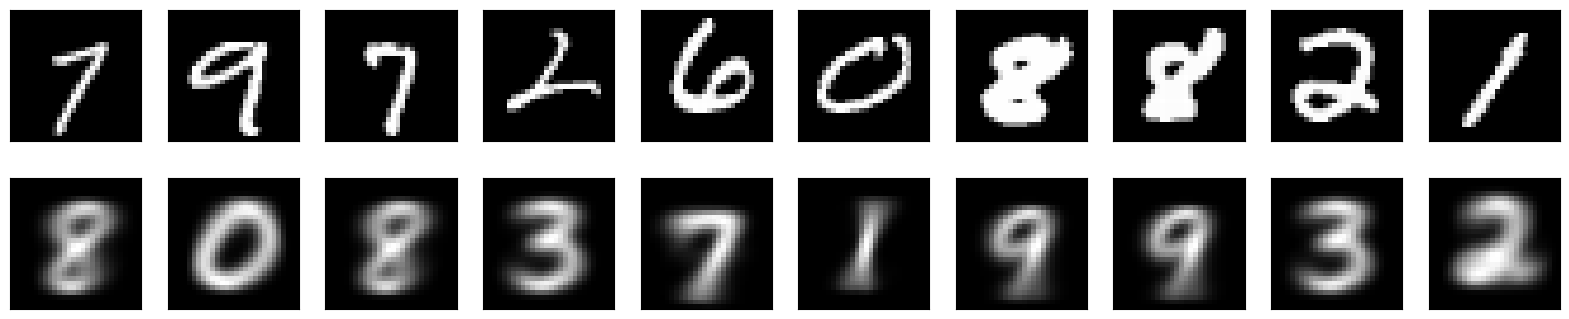

time: 626 ms (started: 2023-12-31 15:29:11 +00:00)


In [31]:
displayReconstructions(x_test, preds)

## Classifying the generated output
Let's try to classify the generated images! We will be using a convolutional auto encoder to perform the classification

In [ ]:
# Create the architecture for the convolutional NN
# Useful info found here
# https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
model_name = 'ConvolutionalNeuralNetwork'

cnn = models.Sequential(name=model_name)

# Add the convolutional layers
cnn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,1)), )
cnn.add(layers.MaxPooling2D((2, 2), name='2x2'))

cnn.add(layers.Conv2D(32, (3, 3), activation='relu',))
cnn.add(layers.MaxPooling2D((2, 2), ))

cnn.add(layers.Flatten()) # Flatten out the filters

cnn.add(layers.Dense(256, activation='relu', name='256neurons'))
cnn.add(layers.Dropout(0.5))
# no dropout layers as of yet
# output
cnn.add(layers.Dense(10, activation='softmax', name='10neurons'))

# Print the model summary!
cnn.summary()

# compile the model
cnn.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
y_train_categorical = keras.utils.to_categorical(y_train)
y_test_categorical = keras.utils.to_categorical(y_test)
history = cnn.fit(x_train, y_train_categorical, epochs=EPOCHS, verbose=2,
                  batch_size=128,
                  validation_data=(x_test, y_test_categorical))

Model: "ConvolutionalNeuralNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 2x2 (MaxPooling2D)          (None, 13, 13, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 800)               0         
                                                                 
 256neurons (Dense)          (None, 256)               205056    
                                        

In [ ]:
# now let's test!
x = preds.reshape(-1, 28,28,1)
y = keras.utils.to_categorical(y_test_1)
score = cnn.evaluate(x, y)

313/313 [==============================] - 3s 9ms/step - loss: 0.9118 - accuracy: 0.6832
time: 5.94 s (started: 2023-12-29 17:18:21 +00:00)


Impressive accuracy of 68% for the generated images!

# Denoiser
In this section we explore the nowadays standard application of how an autoencoder can denoise data

In [19]:
noise = 0.5
x_train_noise = x_train + np.random.normal(loc=0, scale=noise, size=x_train.shape)
x_test_noise = x_test + np.random.normal(loc=0, scale=noise, size=x_test.shape)

# make sure the values do not exceed [0,1]!
x_train_noise = np.clip(x_train_noise, 0, 1)
x_test_noise = np.clip(x_test_noise, 0, 1)

time: 2.25 s (started: 2023-12-31 15:22:26 +00:00)


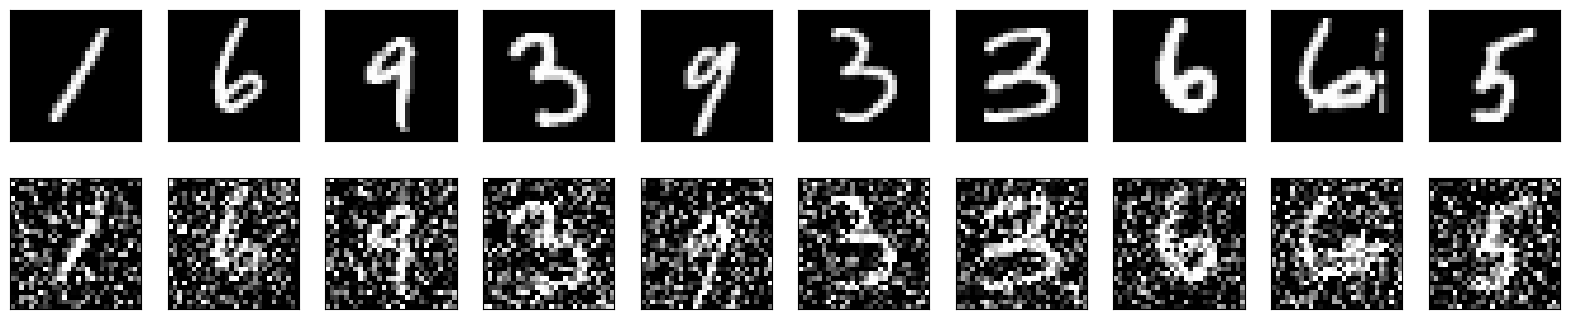

time: 987 ms (started: 2023-12-31 15:22:29 +00:00)


In [20]:
# let's look at a sample of our data
displayReconstructions(x_train, x_train_noise)

In [ ]:
model_name = 'Denoiser'
denoiser = models.Sequential(name=model_name)


# encoder half
denoiser.add(layers.Input((28,28)))
denoiser.add(layers.Reshape((784,)))
denoiser.add(layers.Activation('relu'))
denoiser.add(layers.Dropout(0.2))
denoiser.add(layers.Dense(512, 'relu'))
denoiser.add(layers.Dropout(0.2))
denoiser.add(layers.Dense(256, 'relu'))
denoiser.add(layers.Dropout(0.2))
denoiser.add(layers.Dense(128, 'relu'))
denoiser.add(layers.Dropout(0.2))
# autoencoder.add(layers.Dense(64, 'relu'))
# autoencoder.add(layers.Dense(32, 'relu'))

#decoder half
denoiser.add(layers.Dense(64, 'relu'))
denoiser.add(layers.Dropout(0.2))
denoiser.add(layers.Dense(128, 'relu'))
denoiser.add(layers.Dropout(0.2))
denoiser.add(layers.Dense(256, 'relu'))
denoiser.add(layers.Dropout(0.3))
denoiser.add(layers.Dense(512, 'relu'))
denoiser.add(layers.Dropout(0.3))
denoiser.add(layers.Dense(784, 'sigmoid'))
denoiser.add(layers.Reshape((28,28)))

time: 521 ms (started: 2023-12-29 17:07:18 +00:00)


In [ ]:
denoiser.compile('adam', 'binary_crossentropy', ['accuracy'])
denoiser.fit(x_train_noise, x_train, epochs=EPOCHS, batch_size=128,
                verbose=2, validation_data=(x_test_noise, x_test))

Epoch 1/25
469/469 - 25s - loss: 0.2501 - accuracy: 0.0917 - val_loss: 0.2099 - val_accuracy: 0.1401 - 25s/epoch - 52ms/step
Epoch 2/25
469/469 - 21s - loss: 0.2041 - accuracy: 0.1399 - val_loss: 0.1797 - val_accuracy: 0.1711 - 21s/epoch - 44ms/step
Epoch 3/25
469/469 - 18s - loss: 0.1894 - accuracy: 0.1595 - val_loss: 0.1715 - val_accuracy: 0.1867 - 18s/epoch - 39ms/step
Epoch 4/25
469/469 - 18s - loss: 0.1837 - accuracy: 0.1685 - val_loss: 0.1667 - val_accuracy: 0.1896 - 18s/epoch - 38ms/step
Epoch 5/25
469/469 - 20s - loss: 0.1803 - accuracy: 0.1739 - val_loss: 0.1642 - val_accuracy: 0.1936 - 20s/epoch - 43ms/step
Epoch 6/25
469/469 - 23s - loss: 0.1779 - accuracy: 0.1769 - val_loss: 0.1605 - val_accuracy: 0.1964 - 23s/epoch - 49ms/step
Epoch 7/25
469/469 - 27s - loss: 0.1762 - accuracy: 0.1783 - val_loss: 0.1593 - val_accuracy: 0.2019 - 27s/epoch - 57ms/step
Epoch 8/25
469/469 - 21s - loss: 0.1745 - accuracy: 0.1819 - val_loss: 0.1573 - val_accuracy: 0.2038 - 21s/epoch - 45ms/step


time: 9min 27s (started: 2023-12-29 17:07:19 +00:00)


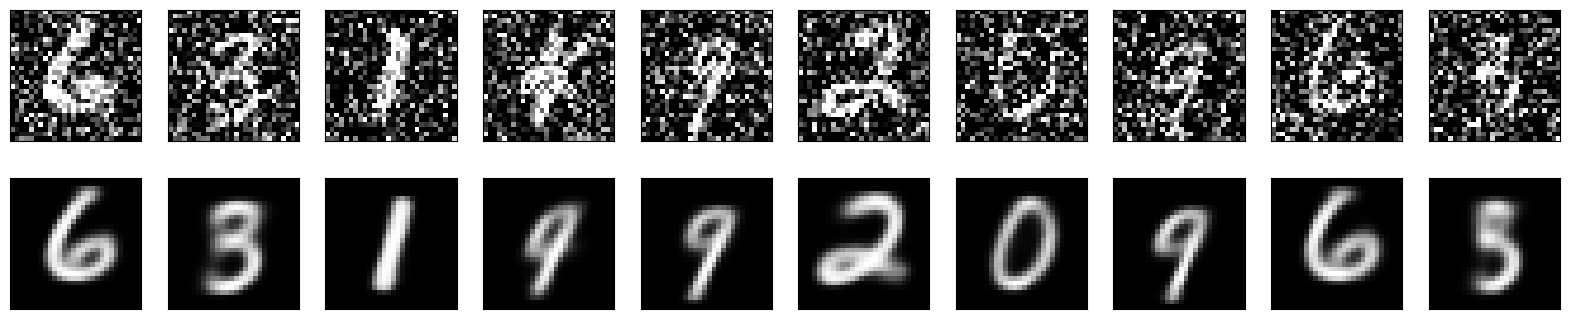

time: 2.2 s (started: 2023-12-29 17:17:28 +00:00)


In [ ]:
denoised_preds = denoiser.predict(x_test_noise)
displayReconstructions(x_test_noise, denoised_preds)

# Adding with autoencoding
Let's try approaching the concept of addition, using an AutoEncoder architecture.

## Creating the image pairs

In [11]:
# first of all let's create the data needed to make an adder
def create_adder_data(x, y):
  """

  """
  def get_instance_index_for_label(x, y, label, ):
    # np.random.seed(SEED)
    indices = np.where(y == label)[0] # this line slows things down a bit
    index = np.random.choice(indices)
    return index
  x1 = x # copy for no particular reason other than readability
  y1 = y
  x2, y2 = x, y
  x2, y2 = sklearn.utils.shuffle(x, y) # shuffle the data, in a later
  xx1 = np.empty(shape=(x.shape))
  xx2 = np.empty(shape=(x.shape))
  yy = np.empty(shape=(y.shape[0], 2), dtype=np.uint8)
  # indices_1 = np.random.choice(x.shape[0], x.shape[0], )
  # indices_2 = np.random.choice(x.shape[0], x.shape[0], )

  for i in range(len(x)):
    # index_1 = np.random.choice(x.shape[0])
    # index_2 = np.random.choice(x.shape[0])
    # add the two labels to have an actual number
    res = y1[i] + y2[i]
    if res < 10:
      yy[i, 0] = 0
      yy[i, 1] = res
    else:
      yy[i, 0] = res // 10
      yy[i, 1] = res % 10

    label1 = yy[i, 0]
    label2 = yy[i, 1]
    random_index_1 = get_instance_index_for_label(x, y, label1)
    random_index_2 = get_instance_index_for_label(x, y, label2)

    # x1, x2, y1, y2 are the original arrays
    # xx1, xx2 and yy hold the results
    # x1[i] = x[index_1]
    # x2[i] = x[index_2]
    # y1[i] = y[index_1]
    # y2[i] = y[index_2]
    xx1[i] = x[random_index_1]
    xx2[i] = x[random_index_2]

  return x1, x2, y1, y2, xx1, xx2, yy

x1_train, x2_train, y1_train, y2_train, xx1_train, xx2_train, yy_train = create_adder_data(x_train, y_train)
x1_test, x2_test, y1_test, y2_test, xx1_test, xx2_test, yy_test = create_adder_data(x_test, y_test)

time: 23.6 s (started: 2023-12-31 14:47:52 +00:00)


In [26]:
def display_adder_reconstructions(x1_orgnl, x2_orgnl, y1_orgnl, y2_orgnl, xx1_orgnl, xx2_orgnl, yy_orgnl):
  """Displays ten random images from each array."""
  n = 10
  # np.random.seed(SEED)
  indices = np.random.randint(len(xx1_orgnl), size=n)
  x1_data = x1_orgnl[indices, :]
  x2_data = x2_orgnl[indices, :]
  y1_data = y1_orgnl[indices]
  y2_data = y2_orgnl[indices]

  xx1_data = xx1_orgnl[indices, :]
  xx2_data = xx2_orgnl[indices, :]
  yy_data = yy_orgnl[indices, :]

  plt.figure(figsize=(20, 8))
  for i, (x1, x2, y1, y2, xx1, xx2, yy) in enumerate(zip(x1_data, x2_data, y1_data, y2_data, xx1_data, xx2_data, yy_data)):
  # for i, (x1, x2, xx1, xx2) in enumerate(zip(x1_data, x2_data, xx1_data, xx2_data)):
      ax = plt.subplot(4, n, i + 1)
      plt.title(str(y1))
      plt.imshow(x1.reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      ax = plt.subplot(4, n, i + 1 + n)
      plt.title(str(y2))
      plt.imshow(x2.reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      ax = plt.subplot(4, n, i + 1 + 2*n)
      # plt.title('Addition of the above = ' + str(yy))
      plt.title(str(yy[0]))
      plt.imshow(xx1.reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      ax = plt.subplot(4, n, i + 1 + 3*n)
      plt.title(str(yy[1]))
      plt.imshow(xx2.reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()
# display_adder_reconstructions(xx1, xx2, yy)

time: 2.34 ms (started: 2023-12-31 15:23:56 +00:00)


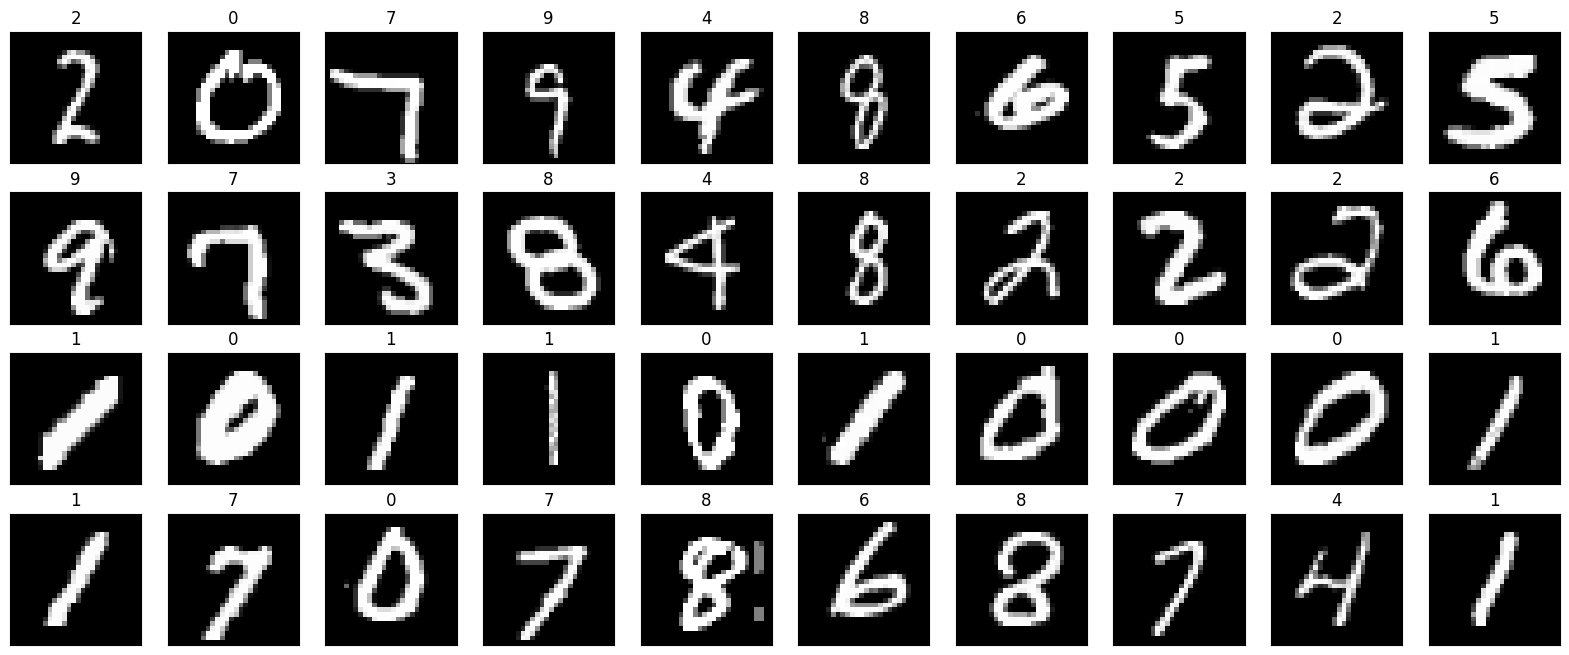

time: 1.27 s (started: 2023-12-31 15:23:58 +00:00)


In [27]:
display_adder_reconstructions(x1_train, x2_train, y1_train, y2_train, xx1_train, xx2_train, yy_train)

## Implementing the adder

In [13]:
x_train_stacked = np.stack([x1_train, x2_train], axis=-1) # axis=-1 stacks elements at the last dimension
y_train_stacked = np.stack([y1_train, y2_train], axis=-1)
xx_train_stacked = np.stack([xx1_train, xx2_train], axis=-1)

x_test_stacked = np.stack([x1_test, x2_test], axis=-1) # axis=-1 stacks elements at the last dimension
y_test_stacked = np.stack([y1_test, y2_test], axis=-1)
xx_test_stacked = np.stack([xx1_test, xx2_test], axis=-1)

time: 903 ms (started: 2023-12-31 14:48:34 +00:00)


In [25]:
model_name = 'ConvolutionalAutoEncoderAdder'
conv_autoencoder = models.Sequential(name=model_name)

conv_autoencoder.add(layers.Input(shape=(28, 28, 2)))

# downscale
conv_autoencoder.add(layers.Conv2D(64, (3,3), activation='relu', padding='same', ))
conv_autoencoder.add(layers.MaxPooling2D(2,2))
conv_autoencoder.add(layers.Conv2D(32, (3,3), activation='relu', padding='same', ))
conv_autoencoder.add(layers.MaxPooling2D(2,2))


# Add middle layer
conv_autoencoder.add(layers.Flatten())
conv_autoencoder.add(layers.Dense(256, activation='relu', ))
conv_autoencoder.add(layers.Dense(7*7*32)) # internal representation
conv_autoencoder.add(layers.Reshape((7, 7, 32), ))

# start upscaling
conv_autoencoder.add(layers.Conv2DTranspose(32, (3,3), activation='relu', padding='same', strides=2, ))
conv_autoencoder.add(layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same', strides=2, ))
conv_autoencoder.add(layers.Conv2D(2, (3,3), activation='sigmoid', padding='same', name='OUT'))

conv_autoencoder.summary()


Model: "ConvolutionalAutoEncoderAdder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        1216      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 2

In [32]:
conv_autoencoder.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = conv_autoencoder.fit(x_train_stacked, xx_train_stacked, epochs=EPOCHS,
          verbose=2, validation_data=(x_test_stacked, xx_test_stacked))

Epoch 1/25
1875/1875 - 307s - loss: 0.2354 - accuracy: 0.3420 - val_loss: 0.2247 - val_accuracy: 0.3336 - 307s/epoch - 163ms/step
Epoch 2/25
1875/1875 - 295s - loss: 0.2232 - accuracy: 0.4056 - val_loss: 0.2191 - val_accuracy: 0.3925 - 295s/epoch - 158ms/step
Epoch 3/25
1875/1875 - 297s - loss: 0.2192 - accuracy: 0.4221 - val_loss: 0.2181 - val_accuracy: 0.4584 - 297s/epoch - 159ms/step
Epoch 4/25
1875/1875 - 299s - loss: 0.2171 - accuracy: 0.4364 - val_loss: 0.2175 - val_accuracy: 0.4446 - 299s/epoch - 159ms/step
Epoch 5/25
1875/1875 - 297s - loss: 0.2156 - accuracy: 0.4487 - val_loss: 0.2174 - val_accuracy: 0.4833 - 297s/epoch - 159ms/step
Epoch 6/25
1875/1875 - 284s - loss: 0.2145 - accuracy: 0.4588 - val_loss: 0.2171 - val_accuracy: 0.4832 - 284s/epoch - 151ms/step
Epoch 7/25
1875/1875 - 294s - loss: 0.2135 - accuracy: 0.4654 - val_loss: 0.2171 - val_accuracy: 0.5171 - 294s/epoch - 157ms/step
Epoch 8/25
1875/1875 - 282s - loss: 0.2127 - accuracy: 0.4762 - val_loss: 0.2168 - val_acc

In [32]:
if False: # load model?
  model_name = 'ConvolutionalAutoEncoderAdder'
  conv_autoencoder = models.load_model(prefix+model_name+'.keras')
  history = loadHistoryFromPickle(prefix+model_name+'.pkl')

if True: # save model?
  model_name = 'ConvolutionalAutoEncoderAdder'
  conv_autoencoder.save(prefix+model_name+'.keras')
  # plot_model(conv_autoencoder, to_file=prefix+model_name'.png')
  saveHistoryToPickle(history, prefix+model_name+'.pkl')

time: 556 ms (started: 2023-12-31 15:30:23 +00:00)


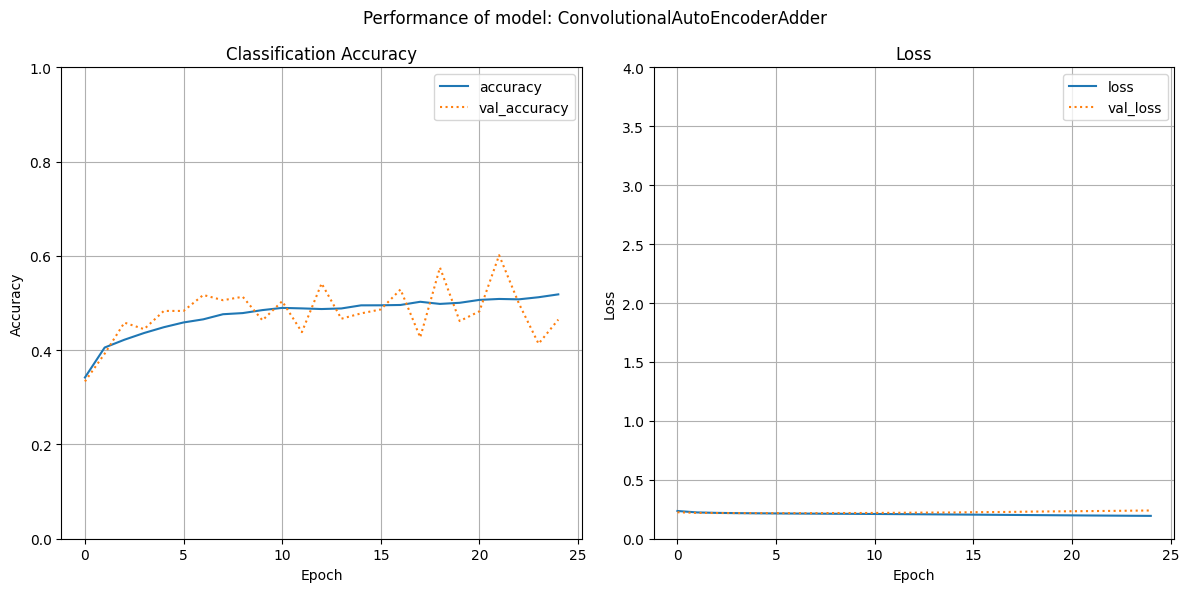

time: 755 ms (started: 2023-12-31 11:50:03 +00:00)


In [34]:
plotModel(model_name, history)

From the accuracy plot above it is obvious that the model needs to be trained for more epochs to get better results.

313/313 [==============================] - 13s 41ms/step


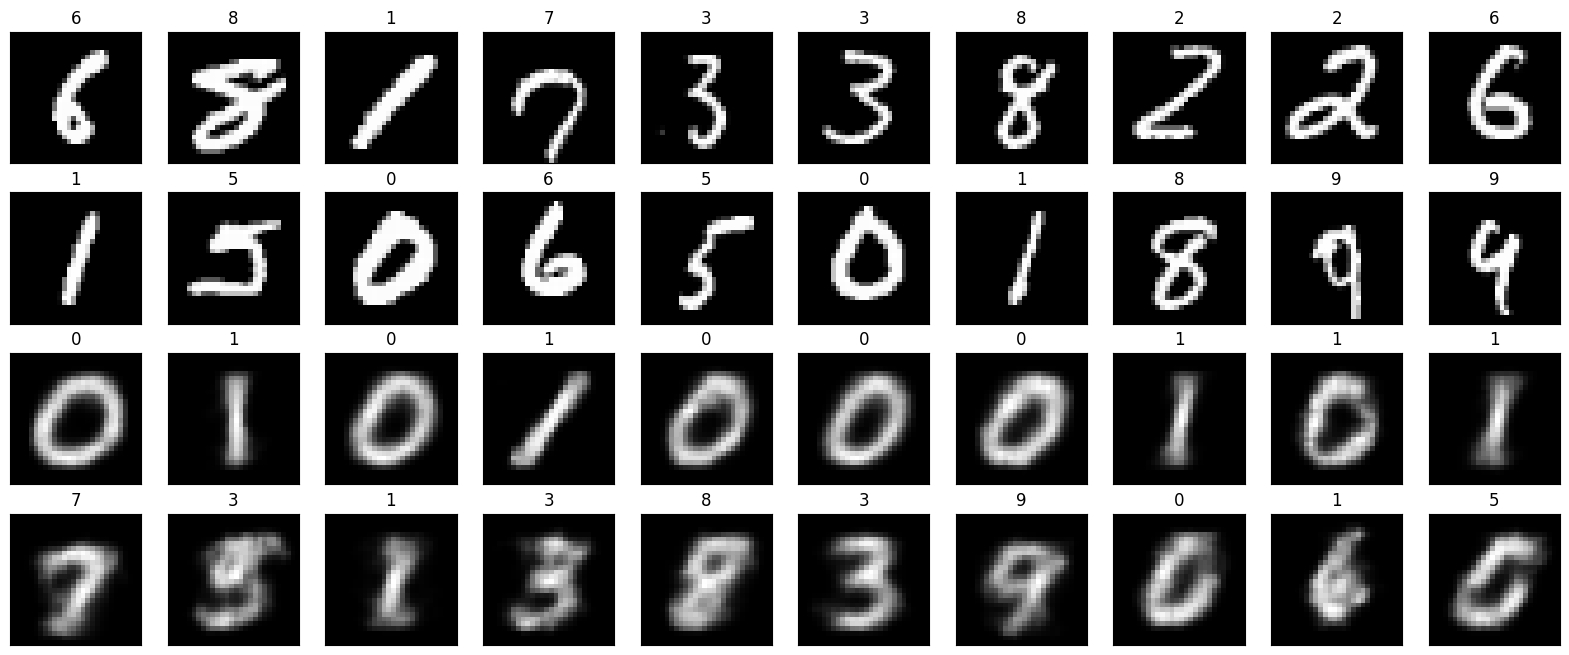

time: 23.1 s (started: 2023-12-31 15:24:12 +00:00)


In [28]:
# unstack/split blocks
preds = conv_autoencoder.predict(x_test_stacked) # this produces a stacked result
# we must split it

a, b = np.split(preds, 2, -1)

display_adder_reconstructions(x1_test, x2_test, y1_test, y2_test, a, b, yy_test)